In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

# Old labview

In [5]:
Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [6]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-06-7"
wnoise = "kilosort_data000/data000"
blanked_probs = 12
spont_limit = 0.25
min_inds = 3

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([-Ivals.reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = 0

clean_inds_array = np.full((all_probs_neg.shape[0], all_probs_neg.shape[1]), 
                            None, dtype=object)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero(all_probs_neg[i][j] >= spont_limit) >= min_inds:
            print(cells[i], j+1)

            clean_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
            clean_inds_array[i][j] = clean_inds

            
            all_probs_neg[i][j][clean_inds] = fitting.disambiguate_sigmoid(all_probs_neg[i][j][clean_inds],
                                                                            spont_limit=spont_limit, noise_limit=0.1)

62 13
62 490
62 491
62 499
62 500
78 5
78 16
78 21
78 25
78 29
78 30
81 10
81 15
81 21
81 24
81 25
81 28
81 30
81 33
81 34
81 37
81 39
81 42
84 2
84 3
84 9
84 10
84 18
84 23
84 26
84 27
84 32
84 35
84 36
84 37
84 44
84 45
84 55
84 62
84 512
84 513
84 514
84 516
85 19
85 27
85 28
85 33
85 34
85 37
87 14
87 22
87 31
87 32
87 40
112 59
112 71
112 77
171 89
171 95
171 104
171 107
171 122
241 12
241 21
241 91
241 105
241 109
241 110
241 114
241 115
241 118
241 119
241 123
241 124
241 126
241 129
244 27
244 45
244 55
244 64
244 75
244 84
244 88
244 93
244 97
244 132
244 133
244 134
244 135
244 136
244 507
244 508
244 509
244 510
244 514
259 17
259 27
259 44
259 45
259 54
259 76
259 104
259 107
259 116
259 117
259 122
259 143
259 144
259 149
259 158
259 501
259 504
259 507
259 508
259 509
259 510
275 165
275 175
275 477
275 479
280 169
282 485
283 176
283 177
283 178
283 186
283 189
283 190
283 191
283 200
283 201
283 340
283 436
283 437
283 438
283 439
283 440
283 441
283 442
283 443
283 444

In [7]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [8]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [9]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
R2s = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]))
probs_true = np.zeros(all_probs_neg.shape)

cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [10]:
EI_cutoff = 10

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials_neg), dtype=int), above_thr_all).astype(int)

Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(579115.5, dtype=float32), DeviceArray(16879.008, dtype=float32), DeviceArray(716695.6, dtype=float32), DeviceArray(137580.16, dtype=float32))
1
(DeviceArray(543625.56, dtype=float32), DeviceArray(13005.783, dtype=float32), DeviceArray(603741.25, dtype=float32), DeviceArray(60115.664, dtype=float32))
2
(DeviceArray(515286.06, dtype=float32), DeviceArray(9104.642, dtype=float32), DeviceArray(533193.25, dtype=float32), DeviceArray(17907.168, dtype=float32))
3
(DeviceArray(483785.12, dtype=float32), DeviceArray(8193.088, dtype=float32), DeviceArray(519923.38, dtype=float32), DeviceArray(36138.242, dtype=float32))
4
(DeviceArray(453692.8, dtype=float32), DeviceArray(8860.119, dtype=float32), DeviceArray(476490.44, dtype=float32), DeviceArray(22797.617, dtype=float32))
5
(DeviceArray(426082.06, dtype=float32), DeviceArray(10531.067, dtype=float32), DeviceArray(436703.4, dtype=float32), DeviceArr

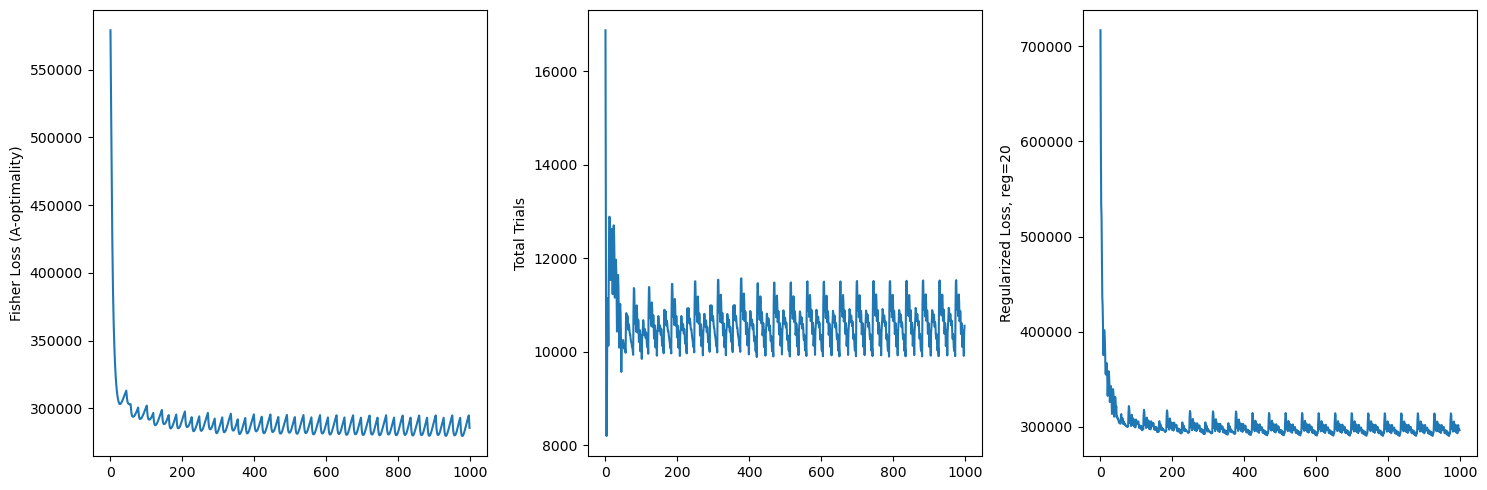

0.057168379277967765 0.057168379277967765


/tmp/ipykernel_51412/1298744225.py:98: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_51412/1298744225.py:111: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(204509.6, dtype=float32), DeviceArray(13180.572, dtype=float32), DeviceArray(268121.03, dtype=float32), DeviceArray(63611.445, dtype=float32))
1
(DeviceArray(205576.78, dtype=float32), DeviceArray(12749.721, dtype=float32), DeviceArray(260571.19, dtype=float32), DeviceArray(54994.414, dtype=float32))
2
(DeviceArray(207890.12, dtype=float32), DeviceArray(10841.857, dtype=float32), DeviceArray(224727.28, dtype=float32), DeviceArray(16837.148, dtype=float32))
3
(DeviceArray(209447.33, dtype=float32), DeviceArray(9239.067, dtype=float32), DeviceArray(224665.98, dtype=float32), DeviceArray(15218.652, dtype=float32))
4
(DeviceArray(205370.98, dtype=float32), DeviceArray(12313.31, dtype=float32), DeviceArray(251637.17, dtype=float32), DeviceArray(46266.19, dtype=float32))
5
(DeviceArray(203646., dtype=float32), DeviceArray(13704.124, dtype=float32), DeviceArray(277728.5, dtype=float32), DeviceArr

<Figure size 640x480 with 0 Axes>

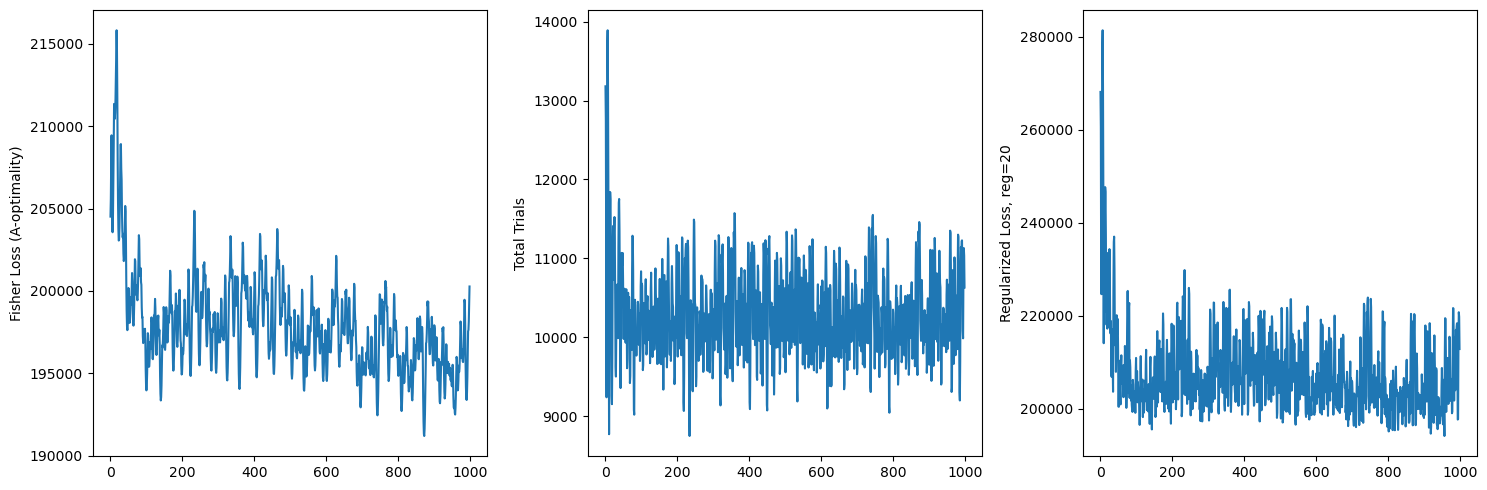

0.03188648055838557 0.043107615645456454


/tmp/ipykernel_51412/1298744225.py:98: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_51412/1298744225.py:111: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(152279.36, dtype=float32), DeviceArray(9533.663, dtype=float32), DeviceArray(161606.1, dtype=float32), DeviceArray(9326.738, dtype=float32))
1
(DeviceArray(149252.19, dtype=float32), DeviceArray(13998.08, dtype=float32), DeviceArray(229213.78, dtype=float32), DeviceArray(79961.6, dtype=float32))
2
(DeviceArray(148788.31, dtype=float32), DeviceArray(15048.291, dtype=float32), DeviceArray(249754.12, dtype=float32), DeviceArray(100965.82, dtype=float32))
3
(DeviceArray(149506.97, dtype=float32), DeviceArray(14497.042, dtype=float32), DeviceArray(239447.81, dtype=float32), DeviceArray(89940.84, dtype=float32))
4
(DeviceArray(150869., dtype=float32), DeviceArray(13013.061, dtype=float32), DeviceArray(211130.22, dtype=float32), DeviceArray(60261.21, dtype=float32))
5
(DeviceArray(152679.14, dtype=float32), DeviceArray(10864.66, dtype=float32), DeviceArray(169972.34, dtype=float32), DeviceArray(1

<Figure size 640x480 with 0 Axes>

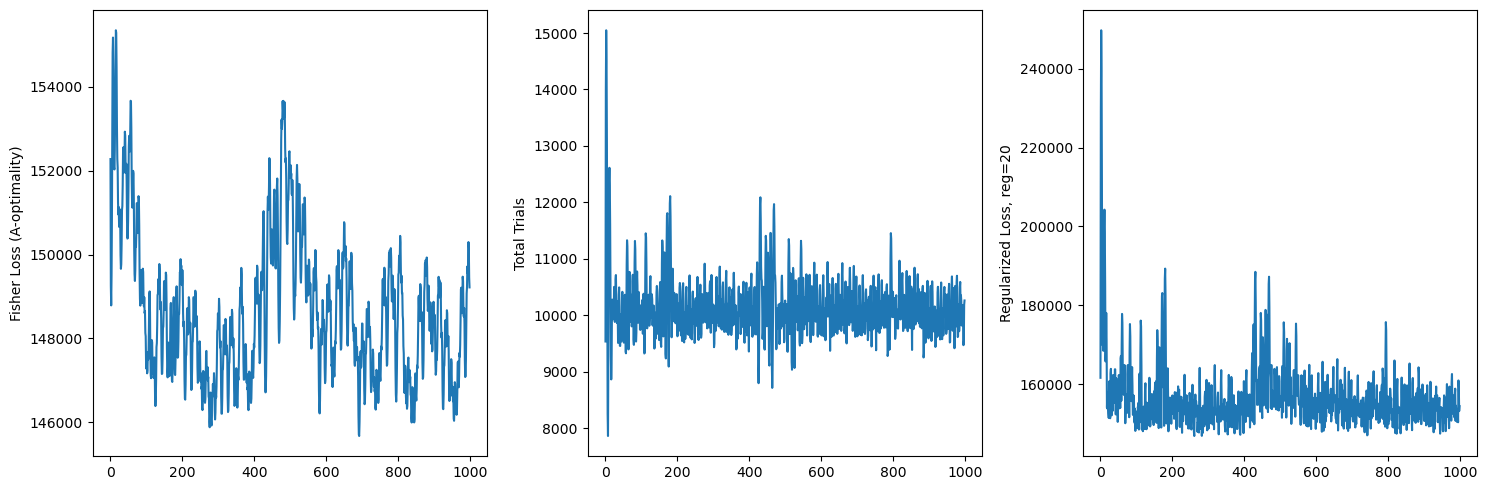

0.026009089512426073 0.035589597914796094


<Figure size 640x480 with 0 Axes>

In [11]:
total_budget = 20000
num_iters = 2
budget = int(total_budget / num_iters)
reg = 20 # 50
T_step_size = 0.25 # 0.05, 0.01
T_n_steps = 1000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials_neg, dtype=float)
T_prev[:, 12::3] = init_trials
T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    # reg = reg * (0.8 ** (iter_cnt))  # UNTESTED
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_neg, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_neg[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    T_new_uniform[:, :11] = 0
    T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [12]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials_neg, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_neg, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

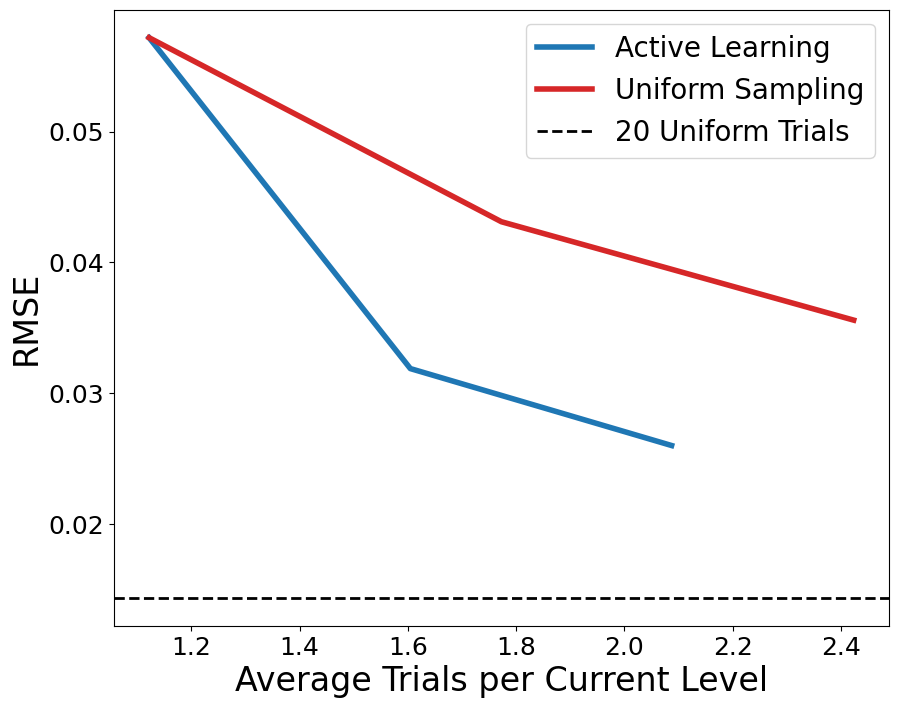

In [13]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials_neg.shape[0]/trials_neg.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials_neg.shape[0]/trials_neg.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps_neg[j], probs_curr[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds_uniform = np.where(T_prev_uniform[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds_uniform], probs_empirical_uniform[i][j][sampled_inds_uniform])
            plt.plot(amps_neg[j], probs_curr_uniform[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

# New labview

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-11-28-6"
wnoise = "kilosort_data000/data000"
blanked_probs = 12

estim_neg = "data002"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=0.3, noise_limit=0.1)
        
all_probs_neg = all_probs_neg[:, :, ::-1]
trials_neg = trials_neg[:, ::-1]
amps_neg = amps_neg[:, ::-1, :]

In [ ]:
estim_pos = "data003"

outpath = os.path.join(GSORT_BASE, dataset, estim_pos, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_pos)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_pos = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_pos = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_pos = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_pos))

all_probs_pos[:, :, :blanked_probs] = np.zeros(all_probs_pos[:, :, :blanked_probs].shape)

for i in range(len(all_probs_pos)):
    for j in range(len(all_probs_pos[i])):
        all_probs_pos[i][j] = fitting.disambiguate_sigmoid(all_probs_pos[i][j], spont_limit=0.3, noise_limit=0.1)

In [ ]:
all_probs = np.concatenate((all_probs_neg, all_probs_pos), axis=2)
trials = np.concatenate((trials_neg, trials_pos), axis=1)
amps = np.concatenate((amps_neg, amps_pos), axis=1)

In [ ]:
T_new, w_inits_array, t_final = fitting.fisher_sampling_1elec(all_probs, trials, amps, T_step_size=0.1, T_n_steps=2000,
                                                                verbose=False, budget=50000) # 0.05 with adam, adamw

In [ ]:
T_new, w_inits_array, t_final = fitting.fisher_sampling_1elec(all_probs, trials, amps, T_step_size=0.1, T_n_steps=2000,
                                                                w_inits_array=w_inits_array,
                                                                t_final=t_final,
                                                                verbose=False, budget=50000) # 0.05 with adam, adamw